## Wordle From Tweeted Scores

Inspired by [Ben Hamner's Kaggle](https://www.kaggle.com/benhamner/wordle-1-6/) and borrowing some methodology, one can predict the wordle of the day simply from publicly shared scores/guesses.

Differences from the kaggle notebook:

* **No simulations of hypothetical games.** I do use a similar word commonality lookup dictionary, and the same [word frequency data](https://www.kaggle.com/rtatman/english-word-frequency).
* **No cosine similarity or comparison of specific (e.g. penultimate) guess.** Only the list, and to some extent count, of all tweeted wordle score lines is needed.
* **No explicit filtering of spurious tweets.** The kaggle data set does some [light filtering](https://www.kaggle.com/benhamner/pull-wordle-tweets), however when I collect them myself, I do not pre-process the search results from the Twitter API. I think using a minimum count threshold mostly eliminates a few fake or spurious scores that were posted.
* **100% Accuracy** This algorithm has 100% accuracy from Wordles 210-228 (the Kaggle project initially failed on 223, though it looks like it was successful on later reruns.)

This notebook uses the precomputed dictionaries inside the `TwitterWordle` class to solve a game from tweets. The other notebook generates the dictionaries.



### Basic Solving Methodology

Each target word has a dictionary that maps a wordle line score `10102` (I map 🟩 to 2, 🟨 to 1, and ⬛ and ⬜ to 0.) to how likely that guess is for the target word. To solve:

1. Count and collect the line scores in public tweets. The order doesn't matter.
2. Using some minimum threshold for using the line score, go through every tweeted line score, and sum the average likelihood score for each unique tweeted score line.
3. Subtract a penalty term if the result is impossible for all 12,000 guessable words. For example, only one word ends in 'uery' : query. It is impossible to guess and get `02222` as a result. There for if `02222` occurred in a tweet, the code would subtract a penalty term for `query` as a possible solution.
4. The target word with the maximum summed lookup frequency is the wordle.


Not every penalty term and minimum count is optimal for every wordle. By default the algorithm uses every tweet available (~2000+), requires at least 5 occurences of the line score, and uses -5E7 (around 1 standard deviation of all frequency scores) as penalty. (That makes it sound like I derived the penalty term in some rigorous way. In fact I just tried a bunch of them, -5E7 worked fairly well, then realized for different wordles, the code should iterate on different values until it finds a strong signal.)

If the top answer is less than 10% higher than the runner up, the code iterates through min counts and penalty terms until it finds a prediction that is, or returns the best one.

In [2]:
import pickle
import re
from collections import Counter
#import plotly.io as pio;# plots should work with matplotlib backend too but ... plotly is better!
#pio.renderers.default = "png" #here only for github, for plotly
from TwitterWordle import TwitterWordle


### Load in data

`tweets.csv` from the [kaggle project](https://www.kaggle.com/benhamner/wordle-tweets). Storing tweets is [complicated](https://developer.twitter.com/en/developer-terms/agreement-and-policy), so I'm not hosting any tweets in this repository, you should download from there. The dataset filters out some spurious tweets, but I have tested this code on unfiltered tweets collected with [searchtweets](https://pypi.org/project/searchtweets-v2/) which you can see in the subsequent section.

You will need to download from there, as there are various rule on storing tweets (i.e. one must delete them if the account goes private), which requires some automation.

In [4]:

#load in the tweet data from kaggle.
df = pd.read_csv("tweets.csv")
t = TwitterWordle(df)


### Solve a Wordle, see a bar graph.

The list of dictionaries is all that is needed to solve from a large number of tweeted results. Below is solving wordle 223, grabbing the tweets from the dataframe `df`. The default parameters are sufficient for most wordles with large N for tweets. The database includes about 2000 or so per tweet.

For wordle 223 below, the default parameters find a very strong signal, so the code does not iterate through other penalty terms and minimum counts.

15776 tweets for wordle 223
53100 guess scores. 153 unique. Min count : 5
Wordle 223 prediction: PERKY. 2.5 STD above mean. 1.35 above runner up.



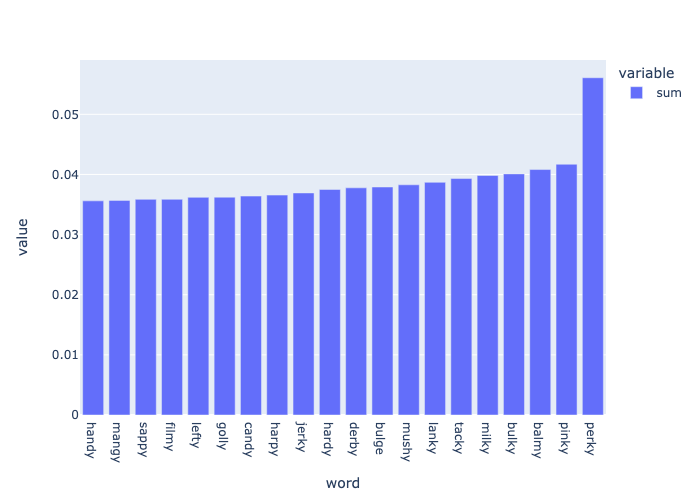

In [5]:

t.solve(223)

The penalty term is averaged in when a wordle score line is impossible for a given target word. However, too high and spurious/fake tweets will penalize real possible target words.

With fewer tweets, the likelihood of bogus tweets is lower, and minimum count can be reduced. Wordle 210 again with a downsampled size and a lower min_count. 

**200 tweets is enough (for some words)!** I lower the min count when downsampling, and the alg iterates through penalty terms until the signal means the 10% threshold.

693 guess scores. 91 unique. Min count : 2
Wordle 223 initial signal low 1.01. Iterating for better parameters
Iterated to a better signal with min_count 1 and penalty -1.30E+08
Wordle 223 prediction: PERKY. 2.8 STD above mean. 1.12 above runner up.



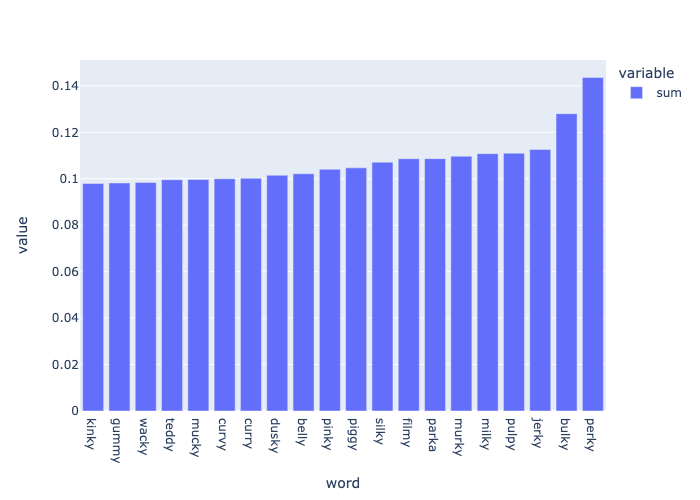

In [6]:
#Solve with only 200 tweets
t.solve(223,downsample=200,min_count=2)

### Solve all test wordles in the test dataframe

In [7]:
t.solve_all()

2837 tweets for wordle 210
7997 guess scores. 137 unique. Min count : 5
Wordle 210 initial signal low 1.09. Iterating for better parameters
Iterated to a better signal with min_count 3 and penalty -7.00E+07
Wordle 210 prediction: PANIC. 1.9 STD above mean. 1.12 above runner up.

2894 tweets for wordle 211
8379 guess scores. 165 unique. Min count : 5
Wordle 211 prediction: SOLAR. 3.1 STD above mean. 1.21 above runner up.

2399 tweets for wordle 212
6813 guess scores. 161 unique. Min count : 5
Wordle 212 prediction: SHIRE. 2.9 STD above mean. 1.33 above runner up.

2119 tweets for wordle 213
7640 guess scores. 96 unique. Min count : 5
Wordle 213 initial signal low 1.01. Iterating for better parameters
Iterated to a better signal with min_count 3 and penalty -1.30E+08
Wordle 213 prediction: PROXY. 2.0 STD above mean. 1.1 above runner up.

2703 tweets for wordle 214
6936 guess scores. 144 unique. Min count : 5
Wordle 214 prediction: POINT. 1.9 STD above mean. 1.2 above runner up.

2943 twe

### Solve with acquired tweets

If you have a Twitter developer account, I have a helper function for [searchtweets](https://pypi.org/project/searchtweets-v2/)  that will pull recent tweets for a given wordle number. It assumes a configuration in `~/.twitter_keys.yaml`.


3083 tweets
7079 guess scores. 151 unique. Min count : 5
Wordle None initial signal low 1.09. Iterating for better parameters
Iterated to a better signal with min_count 3 and penalty -7.00E+07
Wordle None prediction: MOIST. 2.5 STD above mean. 1.3 above runner up.



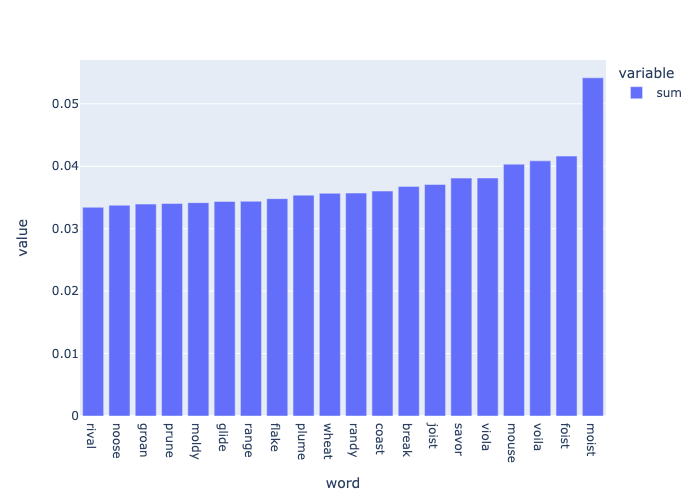

In [3]:
from get_tweets import get_tweets
tweets = get_tweets(228)

from TwitterWordle import TwitterWordle
t = TwitterWordle()
t.solve(tweet_list=tweets)